Описание
----
В данной работе мы покажем как можно использовать данные пакета ALGOPACK для парного трейдинга.

Парный трейдинг (Pairs trading)
--
Парный трейдинг является разновидностью т.н. статистического арбитража, в котором для двух или более инструментов находится устойчивое статистическое свойство, называемое коинтеграцией (не путать с корреляцией). В парном трейдинге такое свойство ищется для пар инструментов.

Коинтеграция
--
По определению, два случайных процесса $A_t$, $B_t$ являются *коинтегрированными* если существует такая их линейная компинация $A_t - h B_t$, что случайный процесс $Z_t = A_t - h B_t$, является стационарным (в широком смысле) случайным процессом. Здесь $h$ является константой.  

Для стационарных (в широком смысле) случайных процессов характерно следующее свойство: такой процесс осциллирует вокруг некоторого среднего значения, и именно на этом свойстве и основана торговая стратегия парного трейдинга.

Как это делается
--
Для парного трейдинга необходимо осуществить следующее:

1. Найти пару коинтегрированных инструментов


2. Найти величину $h$ в линейной комбинации $A_t - h B_t$, которая превращает $A_t - h B_t$ в стационарный (в широком смысле) случайный процесс. Величина $h$ носит специальное название *коэффициент хеджирования  (hedge ratio)*.  Сама такая линейная комбинация $A_t - h B_t$ называется *спрэдом (spread)*.

После того, как находится коинтегрированная пара и коэффициент хеджирования, создается торговая стратегия, суть которой в покупке и продаже спрэда, как портфеля из двух инструментов.   Детали этой стратегии мы представим позже.


Выгрузка исторических данных с сервера Московской Биржы через API ALGOPACK
---

Для наших целей нам потребуется следующая информация об акциях, торгуемых на фондовом рынке Московской Биржи:

1. Полный список акций.


2. Исторические данные торгов по  каждому инструменту, за выбранный период.



Нижеприведенный функционал позволяет получить данную информацию.  Так, полный список акций можно получить используя функцию `get_all_tickers()`, которая возвращает список доступных инструментов. 

Для получения исторический данных мы предоставляем функцию `get_historic_data()`, которая возвращает dataframe из цен закрытия по каждому инструменту (представленны в виде колонок).  В качестве входных параметров данная функция получает спискок акций (`tickers`), и интервал дат.  


Загружаем необходимые библиотеки Python

In [17]:
# ===============================
# Author:  Novichkov Gleb, PhD
# Date:    December 10, 2023
# Licence: MIT License 
# ===============================
from   datetime import datetime
import json

import numpy as np
import statsmodels.api as stats
import statsmodels.tsa.stattools as ts
from   statsmodels.tsa.stattools import adfuller
import pandas as pd
import requests
import seaborn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Необходимые функции по выгрузки данных из информационной системы Мосбиржи, использующие API ALGOPACK

In [18]:
def get_trade_stats(ticker: str, start_date: str, end_date: str):
    url = f'https://iss.moex.com/iss/datashop/algopack/eq/tradestats/{ticker}.csv?from={start_date}&till={end_date}&iss.only=data'
    df = pd.read_csv(url, sep=';', skiprows=2)
    df['Datetime'] = pd.to_datetime(df['tradedate'] + ' ' + df['tradetime'])
    df.set_index("Datetime", inplace=True)
    df.drop(['tradedate', 'tradetime'], inplace = True, axis=1)
    return df

def get_sec_info(market="TQBR"):
    data = requests.get(f'https://iss.moex.com/iss/engines/stock/markets/shares/boards/{market}/securities.json').text
    registry=json.loads(data)
    return pd.DataFrame.from_dict(registry["securities"]["data"])

def get_all_tickers():
    df = get_sec_info()    
    return list(df[0])

def get_close(df):
    return df["pr_close"]

def get_historic_data(tickers: list, start_date: str, end_date: str):
    tbl = pd.DataFrame(columns=tickers)
    for ticker in tickers:
        df = get_trade_stats(ticker, start_date, end_date)
        tbl [ticker] = get_close(df)
    return tbl 

Получение списка акций
----
Найдем все символы, доступные для торговли

In [25]:
all_tickers = get_all_tickers()
print(all_tickers)

['ABIO', 'ABRD', 'ACKO', 'AFKS', 'AFLT', 'AGRO', 'AKRN', 'ALRS', 'AMEZ', 'APTK', 'AQUA', 'ARSA', 'ASSB', 'ASTR', 'AVAN', 'BANE', 'BANEP', 'BELU', 'BISVP', 'BLNG', 'BRZL', 'BSPB', 'BSPBP', 'CARM', 'CBOM', 'CHGZ', 'CHKZ', 'CHMF', 'CHMK', 'CIAN', 'CNTL', 'CNTLP', 'DIOD', 'DSKY', 'DVEC', 'DZRD', 'DZRDP', 'EELT', 'ELFV', 'ENPG', 'ETLN', 'EUTR', 'FEES', 'FESH', 'FIVE', 'FIXP', 'FLOT', 'GAZA', 'GAZAP', 'GAZC', 'GAZP', 'GAZS', 'GAZT', 'GCHE', 'GECO', 'GEMA', 'GEMC', 'GLTR', 'GMKN', 'GTRK', 'HHRU', 'HIMCP', 'HMSG', 'HNFG', 'HYDR', 'IGST', 'IGSTP', 'INGR', 'IRAO', 'IRKT', 'JNOS', 'JNOSP', 'KAZT', 'KAZTP', 'KBSB', 'KCHE', 'KCHEP', 'KGKC', 'KGKCP', 'KLSB', 'KMAZ', 'KMEZ', 'KOGK', 'KRKN', 'KRKNP', 'KRKOP', 'KROT', 'KROTP', 'KRSB', 'KRSBP', 'KTSB', 'KTSBP', 'KUBE', 'KUZB', 'KZOS', 'KZOSP', 'LENT', 'LIFE', 'LKOH', 'LNZL', 'LNZLP', 'LSNG', 'LSNGP', 'LSRG', 'LVHK', 'MAGE', 'MAGEP', 'MAGN', 'MDMG', 'MFGS', 'MFGSP', 'MGNT', 'MGNZ', 'MGTS', 'MGTSP', 'MISB', 'MISBP', 'MOEX', 'MRKC', 'MRKK', 'MRKP', 'MRKS',

Получение исторических данных с 2023-11-20 по 2023-11-30
---
Для нахождения коинтегрированных пар нам потребуются исторические данные без пропусков, которые можно получить с помощью `get_viable_historic_data()`:

In [20]:
def get_viable_historic_data(start_date = '2023-11-20', end_date = '2023-11-30'):
    df = get_historic_data(get_all_tickers(), start_date, end_date)
    df.dropna(axis='columns', inplace=True) #dropping columns with NaNs
    return df

Найдем инструменты, среди которых будем искать коинтегрированные пары:

In [21]:
df_viable = get_viable_historic_data()
tickers = df_viable.columns
print(tickers)

Index(['ABIO', 'AFKS', 'AFLT', 'AGRO', 'ALRS', 'APTK', 'AQUA', 'ASTR', 'BANE',
       'BANEP', 'BELU', 'BSPB', 'CBOM', 'CHMF', 'ENPG', 'ETLN', 'FEES', 'FESH',
       'FIVE', 'FIXP', 'FLOT', 'GAZP', 'GLTR', 'GMKN', 'HNFG', 'HYDR', 'IRAO',
       'KMAZ', 'LKOH', 'MAGN', 'MDMG', 'MGNT', 'MOEX', 'MTLR', 'MTLRP', 'MTSS',
       'MVID', 'NLMK', 'NMTP', 'NVTK', 'OGKB', 'OZON', 'PHOR', 'PIKK', 'PLZL',
       'POLY', 'POSI', 'RASP', 'RENI', 'RNFT', 'ROLO', 'ROSN', 'RTKM', 'RTKMP',
       'RUAL', 'SBER', 'SBERP', 'SELG', 'SFIN', 'SGZH', 'SIBN', 'SNGS',
       'SNGSP', 'SOFL', 'TATN', 'TATNP', 'TCSG', 'TGKA', 'TRMK', 'UNAC',
       'VKCO', 'VTBR', 'WUSH', 'YNDX'],
      dtype='object')


In [23]:
df_viable

,ABIO,AFKS,AFLT,AGRO,ALRS,APTK,AQUA,ASTR,BANE,BANEP,...,TATN,TATNP,TCSG,TGKA,TRMK,UNAC,VKCO,VTBR,WUSH,YNDX
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-11-20 10:05:00,100.40,16.572,38.53,1498.4,66.97,15.060,960.5,545.45,2178.0,1693.5,...,617.5,616.9,3418.5,0.0101,218.46,1.5750,621.8,0.0244,225.33,2578.2
2023-11-20 10:10:00,100.92,16.747,38.79,1499.8,66.95,15.122,960.0,538.85,2187.0,1704.0,...,617.3,617.5,3428.0,0.0101,218.02,1.5825,623.0,0.0245,225.35,2577.4
2023-11-20 10:15:00,100.48,16.699,38.71,1504.6,66.76,15.180,968.5,536.45,2190.5,1698.5,...,615.8,616.1,3422.5,0.0101,218.04,1.5915,622.4,0.0245,225.83,2583.0
2023-11-20 10:20:00,100.52,16.681,38.76,1497.6,66.69,15.166,964.5,529.60,2189.0,1697.5,...,614.8,615.7,3418.5,0.0101,217.62,1.5945,625.8,0.0244,226.16,2564.4
2023-11-20 10:25:00,100.76,16.704,38.74,1499.8,66.74,15.118,964.5,527.00,2190.5,1701.5,...,614.7,615.3,3422.0,0.0101,217.48,1.5800,627.0,0.0245,226.43,2569.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30 18:20:00,95.96,16.212,36.35,1455.4,65.33,13.582,886.5,481.90,2447.0,1732.0,...,641.9,638.9,3345.0,0.0094,205.70,1.2820,615.4,0.0236,224.25,2553.8
2023-11-30 18:25:00,95.74,16.213,36.35,1454.8,65.40,13.622,887.0,481.90,2433.5,1733.0,...,641.9,638.6,3354.0,0.0093,205.98,1.2800,615.4,0.0236,224.29,2553.8
2023-11-30 18:30:00,96.00,16.210,36.39,1457.6,65.32,13.594,886.5,481.90,2431.5,1731.0,...,642.0,638.1,3360.0,0.0093,205.92,1.2825,616.4,0.0236,224.57,2550.0


Нахождение коинтегрированных пар инструментов
---

Для нахождения пар коинтегрированных инструментов мы воспользуемся линейной регрессией между временными рядами пар инструментов и расширенным тестом Дикки – Фуллера (Augmented Dickey-Fuller test), который применим к остаткам регрессии.  ADF тест возвращает несколько значений, среди которых важными для нас являются p-значение и тестовая статистика.

Нулевая гипотеза $H_0$ теста состоит в том, что два временных ряда не коинтегрированны. Если p-значение ниже заранее заданного порогового значения (в нашем случае это 1%) и тестовая статистика меньше критического значения для данного уровня (1%), то мы отвергаем нулевую гипотезу и считаем данные временные ряды коинтегрированными.

Данная проверка на коинтеграцию реализована функцией `is_cointegrated()`.  Функция возвращает 3 значения: статус (Тrue если коинтеграция есть, False если нет), p-значение, и коэффициент хеджирования.  В случае отсутствия коинтеграции (статус равен False), p-значеe и коэффициент хеджирования равны нулю.

Поиск коинтегрированных пар осуществляется функцией `find_cointegrated_pairs()`, которая возвращает список таких пар, матрицу p-значений, и матрицу коэффициентов хеджирования

In [27]:
# =========================================================
# Утилиты для нахождения пар коинтегрированных инструментов
# =========================================================

# Определяет, является ли пара временных рядов коинтегрированной. 
def is_cointegrated(y, x, p_value_threshold = 0.01):
    model = stats.OLS(y, x).fit()
    hedge_ratio = model.params[0]
    spread = y - hedge_ratio*x
    adf_result = ts.adfuller(spread)
    p_value = adf_result[1]
    adf_statistics = adf_result[0]
    if adf_statistics<=adf_result[4]["1%"] and p_value<=p_value_threshold:
        return True, p_value, hedge_ratio, 
    else:
        return False, 0, 0
    
# Находит пары коинтегрированных инструментов
def find_cointegrated_pairs(df: pd.DataFrame, threshold: float = 0.01):
    ncols = df.shape[1]
    cointegrated_pairs = []
    hedge_ratio_matrix = np.zeros((ncols, ncols))
    p_value_matrix= np.ones((ncols, ncols))
    for i in range(ncols):
        for j in range(ncols):
            if j == i:  continue
            cointegrated, p_value, hedge_ratio  = is_cointegrated(df.iloc[:,i], df.iloc[:,j])

            if cointegrated:
                hedge_ratio_matrix[i,j] = hedge_ratio
                p_value_matrix[i,j]=p_value
                cointegrated_pairs.append((df.columns[i], df.columns[j]))

    return cointegrated_pairs, p_value_matrix, hedge_ratio_matrix

Найдем коинтегрированные пары, матрицу p-значений, матрицу коэффициентoв хеджирования (`hedge_ratio_matrix`) по первому дню (`2023-11-20`).  В одной торговой сессии 104 пятиминутных интервала, поэтому выбираем `one_day_lookback=104` .

In [29]:
one_day_lookback=104  

cointegrated_pairs, p_value_matrix, hedge_ratio_matrix = find_cointegrated_pairs(df_viable[:one_day_lookback])

Посмотрим, как выглядит матрица p-значений

<AxesSubplot: >

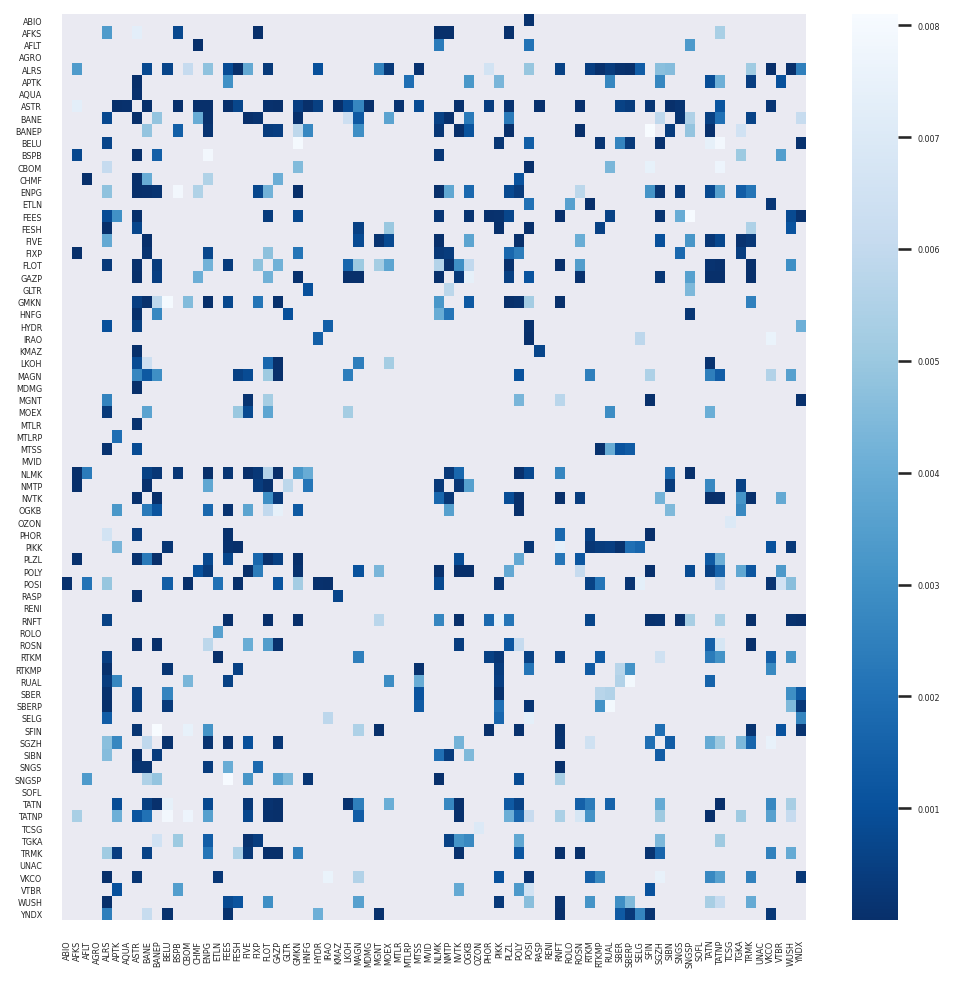

In [35]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 150

tickers = list(df_viable.columns)

seaborn.set(font_scale=0.35)
seaborn.heatmap(p_value_matrix, xticklabels=tickers, yticklabels=tickers, cmap = "Blues_r", 
                           mask = (p_value_matrix >= 0.99))

Посмотрим, какие коинтегрированные пары мы нашли. Также узнаем p-значение и коэффицент хеджирования для каждой такой пары.

In [39]:
for y, x in cointegrated_pairs:
    y_idx = tickers.index(y)
    x_idx = tickers.index(x)
    p_value = p_value_matrix[y_idx, x_idx]
    hedge_ratio = hedge_ratio_matrix[y_idx, x_idx]
    print("(%5s, %5s), p-value: %e, hedge ratio: %f"%(y, x, p_value, hedge_ratio))

( ABIO,  POSI), p-value: 6.511128e-05, hedge ratio: 0.047485
( AFKS,  ALRS), p-value: 3.356319e-03, hedge ratio: 0.250379
( AFKS,  ASTR), p-value: 7.296003e-03, hedge ratio: 0.031808
( AFKS,  BSPB), p-value: 7.463958e-04, hedge ratio: 0.067777
( AFKS,  FIXP), p-value: 5.116691e-06, hedge ratio: 0.048572
( AFKS,  NLMK), p-value: 2.641343e-06, hedge ratio: 0.088294
( AFKS,  NMTP), p-value: 8.447161e-08, hedge ratio: 1.374289
( AFKS,  PLZL), p-value: 4.724120e-05, hedge ratio: 0.001484
( AFKS, TATNP), p-value: 5.342229e-03, hedge ratio: 0.027116
( AFLT,  CHMF), p-value: 1.676519e-05, hedge ratio: 0.028762
( AFLT,  NLMK), p-value: 2.327079e-03, hedge ratio: 0.204166
( AFLT,  POSI), p-value: 2.098444e-03, hedge ratio: 0.018239
( AFLT, SNGSP), p-value: 3.345041e-03, hedge ratio: 0.656857
( ALRS,  AFKS), p-value: 3.356236e-03, hedge ratio: 3.993893
( ALRS,  BANE), p-value: 7.757929e-04, hedge ratio: 0.030030
( ALRS,  BELU), p-value: 6.528736e-04, hedge ratio: 0.011871
( ALRS,  CBOM), p-value:

Как видим, NVTK (ПАО «НОВАТЭК») и BANEP (привелигированные акции АНК "Башнефть") образуют коинтегрированную пару;  коэффициент хеджирования для нее равен $0.905173$.  p-значение для этой пары очень низкое, 2.035215e-05, то есть 0.002%, поэтому с вероятностью 99.998% можно считать что эта пара действительно коинтегрирована.  

Таким образом $Z_t = \mathrm{NVTK}_t - 0.905173\cdot\mathrm{BANEP}_t$ должен быть стационарным (в широком смысле) случайным процессом. Выберем данную пару для последующего построения торговой стратегии.

In [43]:
#  ==================================================
#               Pairs Trading Strategy
#               ----------------------
#  Cointegrated pair: NVTK, BANEP
#  Hedge ratio: 0.905173
#
#  NVTK - 0.905173* BANEP ~ stationary stoch. process
#  ==================================================

df = df_viable[["NVTK", "BANEP"]].copy()

Найдем коэффициент хеджирования для данных инструментов, спред, и построим график спреда:

In [44]:
NVTK_idx = tickers.index("NVTK")
BANEP_idx = tickers.index("BANEP")
hedge_ratio = hedge_ratio_matrix[NVTK_idx, BANEP_idx]
df["spread"] = df["NVTK"] - hedge_ratio*df["BANEP"]

<AxesSubplot: xlabel='Datetime'>

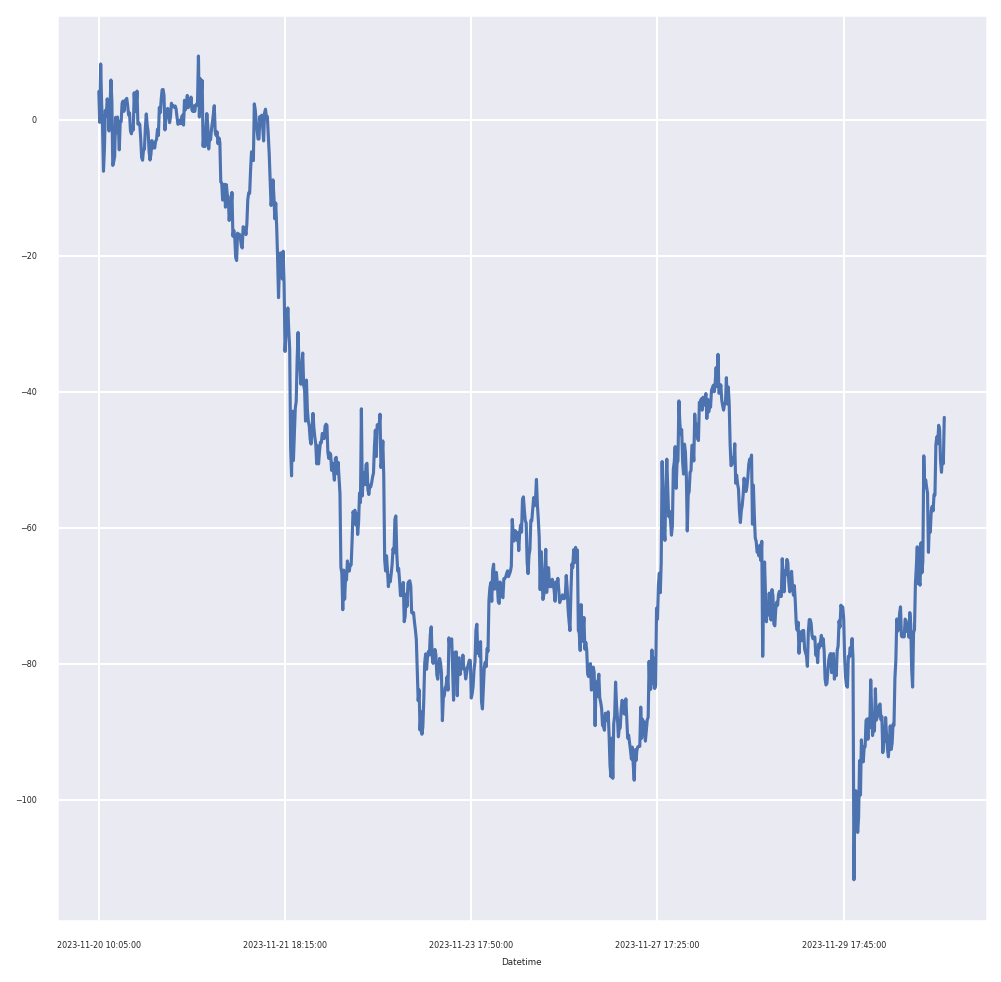

In [45]:
df_plot = df.copy()
df_plot.index=df_plot.index.astype("str") #  делаем это для того, чтобы убрать масштабирование по датам
df_plot["spread"].plot() 

Торговая стратегия
---
Для спреда построим скользящее среднее, и две полосы, отстоящие на одно стандартное отклонение от скользящего среднего.  Покупку или продажу спреда, как портфеля из NVTK и BANEP, будем осуществлять согласно следующему правилу: покупаем спред (то есть портфель $\mathrm{NVTK}_t - 0.905173\cdot\mathrm{BANEP}_t$) в тот когда спред ниже нижней полосы, шортим спред, когда спред выше верней полосы. Когда спред внутри полос, закрываем позицию (продаем или выкупаем спред, соответственно).

В деталях: 
- покупка 1 единицы спреда : покупка 1 контракта NVTK, продажа 0.905173 контракта BANEP
- продажа 1 единицы спреда: продажа 1 контракта NVTK, покупка 0.905173 контракта BANEP

Ценами, по которым происходит покупка/продажа контрактов, будем считать цены закрытия NVTK и BANEP на данный интервал времени.

Приводим код для построения верней и нижней полос, а также для построения графика:

<AxesSubplot: xlabel='Datetime'>

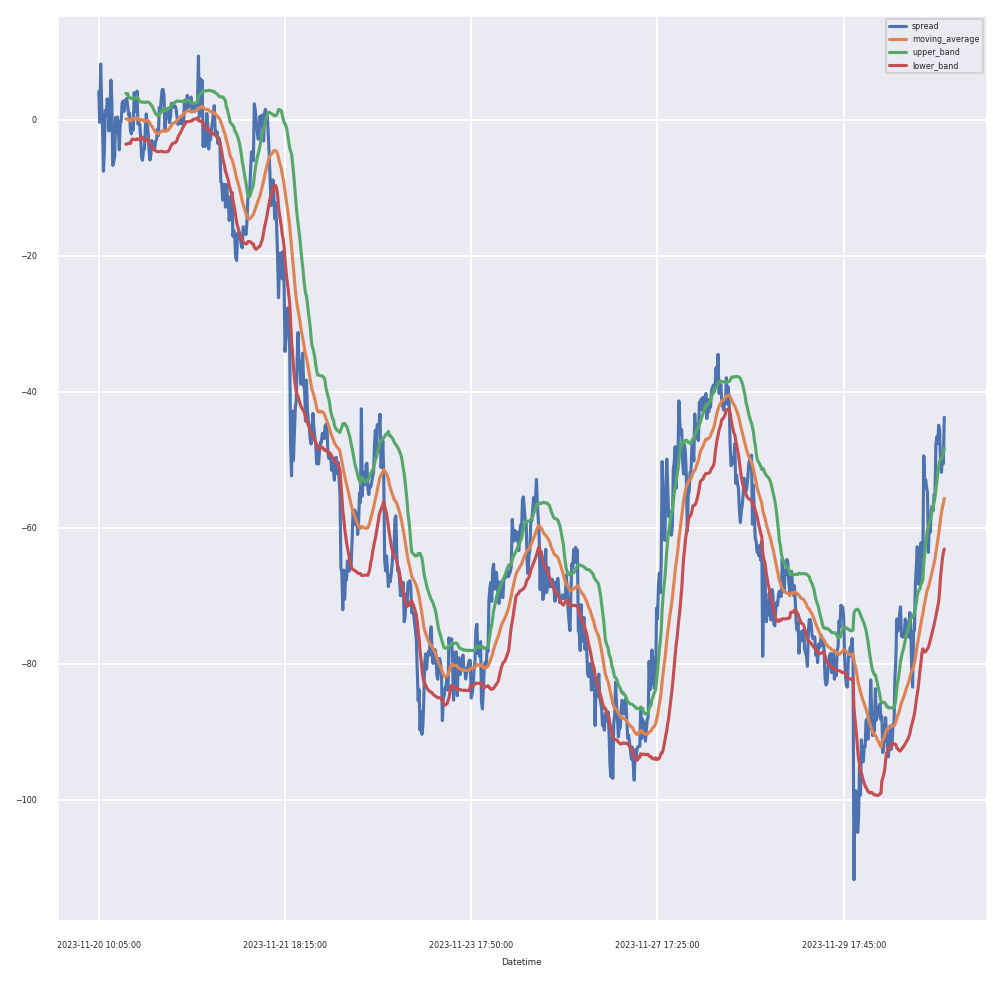

In [46]:
num_std = 1.0         # кол-во стандартных отклонений от скользящего среднего
movagv_lookback = 30  # считаем скользящее среднее и скользящее станартное отклонение 
                      # за последние 30 пятиминутных интервалов
df["moving_average"] = df["spread"].rolling(movagv_lookback).mean()
df["moving_stdev"] = df["spread"].rolling(movagv_lookback).std()
df["upper_band"] = df["moving_average"] + num_std*df["moving_stdev"]
df["lower_band"] = df["moving_average"] - num_std*df["moving_stdev"]

# Построим графики спреда с верхней и нижней полосами
df_plot = df.copy()
df_plot.index=df_plot.index.astype("str")
df_plot[["spread","moving_average","upper_band","lower_band"]].plot()


Реализация торговой стратегии
---
В датафрейме создадим дополнительнительные колонки, где будем записывать принятое действие, позицию (в спредах), и баланс (в рублях).

In [74]:
df["action"] = ""
df["position"] = 0
df["balance"] = 0
position = 0  # в спредах
balance = 0

Главный цикл стратегии
---

In [75]:
for i in range(df.shape[0]):  
    spread = df["spread"][i]
    price_NVTK = df["NVTK"][i]
    price_BANEP = df["BANEP"][i]
    
    lower_band = df["lower_band"][i]
    upper_band = df["upper_band"][i]
    
    moving_avg = df["moving_average"][i]

    if np.isnan(moving_avg): # не делаем ничего, пока нет валидных данных
        continue
    
    if i == df.shape[0]-1:
        # последний интервал в данных, закрываем все позиции
        if position == 1:
            df.at[df.index[i], "action"] = "CLOSING: GO FLAT from 1 to 0"
            # продаем 1 спред, для чего продаем 1 контракт NVTK и покупаем hedge_ratio*1 контрактов BANEP
            balance += price_NVTK*1 - hedge_ratio*price_BANEP*1
            position = 0
            
        elif position == -1:
            df.at[df.index[i], "action"] = "CLOSING: GO FLAT from -1 to 0"
            # покупаем 1 спред, для чего покупаем 1 контракт NVTK и продаем hedge_ratio*1 контрактов BANEP
            balance += -price_NVTK*1 + hedge_ratio*price_BANEP
            position = 0
        
        df.at[df.index[i], "balance"] = balance
        df.at[df.index[i], "position"] = position
        
        break

    # сигналы покупки/продажи, если выходим за верхнюю/нижнюю полосы
    if spread<=lower_band:

        if position == 0:
            df.at[df.index[i], "action"] = "GO LONG from 0 to 1"
            # покупаем 1 спред, для чего покупаем 1 контракт NVTK и продаем hedge_ratio*1 контрактов BANEP
            balance += -price_NVTK*1 + hedge_ratio*price_BANEP
            position  = 1

        elif position == -1:
            df.at[df.index[i], "action"] = "GO LONG from -1 to 1"
            # покупаем 2 спреда, для чего покупаем 2 контракта NVTK и продаем hedge_ratio*2 контрактов BANEP
            balance += -price_NVTK*2 + hedge_ratio*price_BANEP*2
            position  = 1

    elif spread>=upper_band:
        if position == 0:
            df.at[df.index[i], "action"] =  "GO SHORT from 0 to -1"
            # продаем 1 спред, для чего продаем 1 контракт NVTK и  покупаем hedge_ratio*1 контрактов BANEP
            balance += price_NVTK*1 - hedge_ratio*price_BANEP*1
            position = -1

        elif position == 1:
            df.at[df.index[i], "action"] = "GO SHORT from 1 to -1"
            # продаем 2 спреда, для чего продаем 2 контракта NVTK и покупаем hedge_ratio*2 контрактов BANEP
            balance += price_NVTK*2 - hedge_ratio*price_BANEP*2
            position = -1
    else:
        # внутри полос, должны закрыть позицию
        if position == 1:
            df.at[df.index[i], "action"] = "GO FLAT from 1 to 0"
            # продаем 1 спред, для чего продаем 1 контракт NVTK и  покупаем hedge_ratio*1 контрактов BANEP

            balance += price_NVTK*1 - hedge_ratio*price_BANEP*1
            position = 0
        elif position == -1:
            df.at[df.index[i], "action"] = "GO FLAT from -1 to 0"
            # покупаем 1 спред, для чего покупаем 1 контракт NVTK и продаем hedge_ratio*1 контрактов BANEP
            balance += -price_NVTK*1 + hedge_ratio*price_BANEP
            position = 0
    # учет денег и позиции по спреду
    df.at[df.index[i], "balance"] = balance
    df.at[df.index[i], "position"] = position
    
print(f"Balance: {np.round(balance,2)}")

Balance: 159.45


Как видим, стратегия заработала 159 рублей. Посмотрим, что происходило, какие действия совершала стратегия. Обращаем внимание, что в каждом периоде мы показываем какая была позиция (в спредах) до момента совершения сделки и после совершения сделки (если таковая была).

In [76]:
print("Datetime           :pos-1: pos:   PnL  : Action")
print("===============================================")

for i in range(1,df.shape[0]):
    print("%s : %2d : %2d : %6.2f : %s"%(
        df.index[i], df["position"][i-1], df["position"][i], 
        df["balance"][i], df["action"][i]))

Datetime           :pos-1: pos:   PnL  : Action
2023-11-20 10:10:00 :  0 :  0 :   0.00 : 
2023-11-20 10:15:00 :  0 :  0 :   0.00 : 
2023-11-20 10:20:00 :  0 :  0 :   0.00 : 
2023-11-20 10:25:00 :  0 :  0 :   0.00 : 
2023-11-20 10:30:00 :  0 :  0 :   0.00 : 
2023-11-20 10:35:00 :  0 :  0 :   0.00 : 
2023-11-20 10:40:00 :  0 :  0 :   0.00 : 
2023-11-20 10:45:00 :  0 :  0 :   0.00 : 
2023-11-20 10:50:00 :  0 :  0 :   0.00 : 
2023-11-20 10:55:00 :  0 :  0 :   0.00 : 
2023-11-20 11:00:00 :  0 :  0 :   0.00 : 
2023-11-20 11:05:00 :  0 :  0 :   0.00 : 
2023-11-20 11:10:00 :  0 :  0 :   0.00 : 
2023-11-20 11:15:00 :  0 :  0 :   0.00 : 
2023-11-20 11:20:00 :  0 :  0 :   0.00 : 
2023-11-20 11:25:00 :  0 :  0 :   0.00 : 
2023-11-20 11:30:00 :  0 :  0 :   0.00 : 
2023-11-20 11:35:00 :  0 :  0 :   0.00 : 
2023-11-20 11:40:00 :  0 :  0 :   0.00 : 
2023-11-20 11:45:00 :  0 :  0 :   0.00 : 
2023-11-20 11:50:00 :  0 :  0 :   0.00 : 
2023-11-20 11:55:00 :  0 :  0 :   0.00 : 
2023-11-20 12:00:00 :  0 :  

Посмотрим на графике, как менялся баланс с течением времени.  График будем строить по тем точкам, когда позиция по спреду была нулевая.

<AxesSubplot: xlabel='Datetime'>

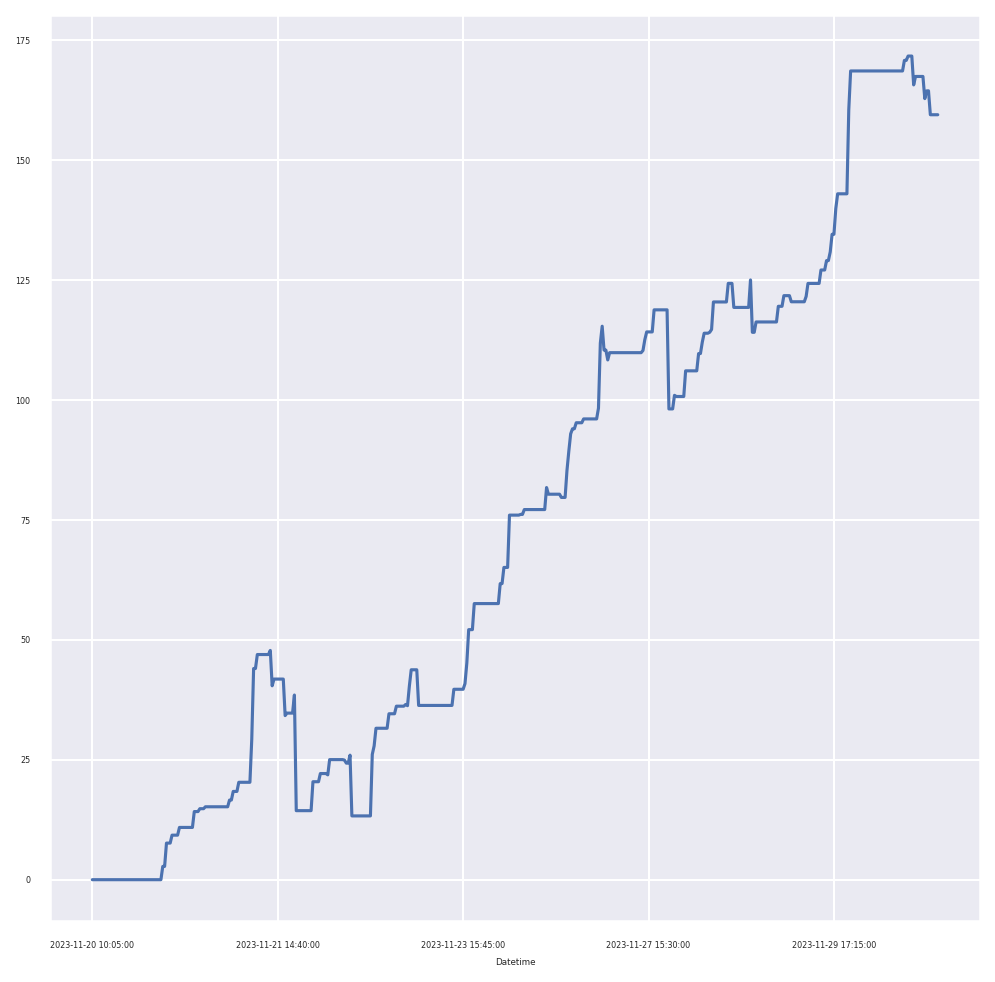

In [85]:
df_plot = df.copy()
df_plot.index=df_plot.index.astype("str")
df_plot.loc[df_plot['position'] == 0]["balance"].plot()

Выводы
---
Как видим, данная простая стратегия оказалась прибыльной.  

Данные о PnL, собранные в процессе бэктестирования,  в принципе позволяют оценить риск-метрики данной стратегии, но для простоты изложения мы ограничимся визуальной оценкой графика PnL: как мы видим PnL растет, хотя и неравномерно.  Maximum Drawdown, как мы видим, составляет 75 руб (время: 2023-11-21 14:40:00).

Ограничения данной модели
---------

В данной модели присутствуют следующие ограничения:

1. Мы не учитываем стоимость транзакций, при подсчете баланса мы исходили из того, что она нулевая.  В реальности же стоимость транзакции не нулевая, и ее всегда следует учитывать. Также следует учитывать дополнительные расходы, возникающие при коротких продажах акции.


2. Мы считали что всегда можно купить дробное число контрактов BANEP, точнее 0.905173 контракта. В реальности же размер лота BANEP равен 1 (размер лота NVTK также равен 1), и это минимальное число контрактов которое можно купить или продать на Московской Бирже.  Обойти такое ограничение можно, например, увеличив количество спредов на покупку/продажу.  Так, для покупки 10 спредов нам будет необходимо купить 10 контрактов NVTK и продать 9 контрактов BANEP.


3. Модель предполагает, что рынок данных инструментов ликвиден, и мы всегда можем купить/продать актив без задержки и без существенной потери в цене. Для данных двух инструментов рынок достаточно ликвиден, но в общем случае инструменты могут быть неликвидны. Поэтому иструменты для парного трейдинга следует выбирать внимательно